# State Estimation

For state estimation, we consider the stochastic differential model

$$ \dot{x} = f(x;t) + \eta(t) $$
$$ z(t) = h(x;t) + \nu(t) $$

We assume $\eta$ and $\nu$ are independent, Gaussian distributed noise processes. Discrete  measurements $z(t)$ are used to estimate latent states $x$ over time $t$.

In ```demo_01```, we used $y$ to represent the state governed by the differential equation which is common notation for time-varying differential equations. Here we use $x$ to represent the state which evolves in time governed by a stochastic differential equation. Here $z$ represents measurements which are modeled with a non-differential equation of the latent state. As a convenience, we use $y$ to represent the so-called "innovation."

$$ y(t) = z(t) - h(x;t) $$


In [1]:
# Setup
import numpy as np
import scipy
import matplotlib.pyplot as plt
plt.style.use('default')
import statsmodels.api as sm    # qqplot

import os
print(os.environ['CONDA_DEFAULT_ENV'])

LINEAR_DIFF_EQ = True
LINEAR_MEAS = True

# Helper function
def qqplot(data,mu,sigma2,title=""):
    '''QQ-Plot of scalar data against parameterized Gaussian'''
    sm.qqplot(data, loc = mu, scale = np.sqrt(sigma2) ,  line='45')
    plt.text(0.6, 0.2, 'Gaussian\n$\mu$ = %.4g\n$\sigma^2$ = %.4g'%(mu,sigma2), 
             bbox=dict(fill="True", edgecolor='red', linewidth=2, facecolor='w'), transform=plt.gca().transAxes)    
    plt.grid()
    if title:
        plt.title(title)
        
class GaussianRv():
    '''Parametric representation of Gaussian-distributed RV. Also used to generate realizations'''
    def __init__(self,mu=0,sigma2=1):
        self.mu = mu
        self.sigma2 = sigma2
        self.rng = rng
    
    def realization(self,shp=1,rng=np.random.default_rng(0)):
        if self.sigma2 == 0.0:
            rslt = np.zeros(shp)
        else:
            rslt = rng.normal(self.mu,np.sqrt(self.sigma2),shp)
        return rslt
    
    def serialize(self):
        return np.array([self.mu,self.sigma2])
        
    @staticmethod
    def fromserial(dat):
        assert(len(dat)==2)
        return GaussianRv(dat[0],dat[1])
        
    

if LINEAR_DIFF_EQ:
    # Model parameters
    alpha = 0.1

    # Functions
    state_diff = lambda tau, x : alpha*x
    prop_eval = lambda tau, x : np.exp(alpha * tau)*x
    prop_jacob = lambda tau, x : np.exp(alpha * tau)       
    
else:
    # Functions
    state_diff = lambda tau, x : x**2
    prop_eval = lambda tau, x : np.divide(x,1-tau*x)
    prop_jacob = lambda tau, x : np.divide(1,(1-tau*x)**2)

if LINEAR_MEAS:
    alpha = 3
    meas_eval = lambda x : alpha*x
    meas_jacob = lambda x : alpha
    
else:
    meas_eval = lambda x : x**2
    meas_jacob = lambda x : 2*x


# Trivial 
#state_diff = lambda tau, x : 1
#prop_eval = lambda tau, x : x
#prop_jacob = lambda tau, x : 1

# Domain
N_realizations = 10000
N_timesteps = 100
N_meas_downsample = 10

# Generate initial condition
rng = np.random.default_rng(12345)

# Define priors
prior_x0 = GaussianRv(
    mu=10.,
    sigma2=2.)
prior_eta = GaussianRv(
    sigma2=0.1)
prior_nu = GaussianRv(
    sigma2=1)

t_all = np.linspace(0, 0.3, N_timesteps)
idx_meas = slice(N_meas_downsample,t_all.size,N_meas_downsample)
t_meas = t_all[idx_meas]


stateest


## Generate "true" process realizations
We assume the processes is unobserved and evolves according to the stochastic differential equation. However, a realization is required to compute measurements. First we generate realizations of the stochastic process.

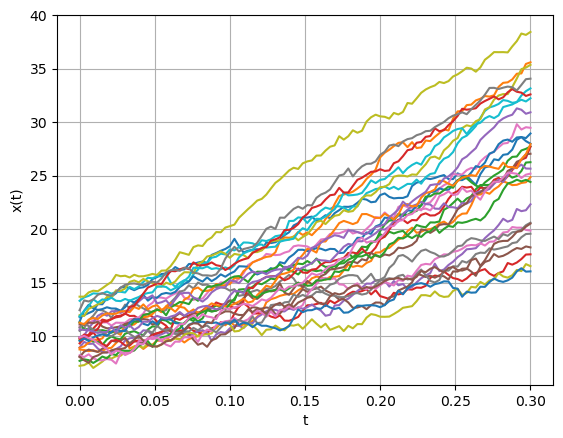

In [2]:
# Generate "truth" processes realizations

x_0 = prior_x0.realization(N_realizations,rng)
eta = prior_eta.realization([t_all.size,x_0.size],rng)

#  For each realization of x_0, compute x_t for all t
x_t = np.zeros(eta.shape)
x_t[0,:] = x_0
for idx_t in range(1,t_all.size):
    tau = t_all[idx_t]-t_all[idx_t-1]
    #print("t index %d, tau = %g"%(idx_t,tau))
    
    for idx_x in range(0,x_0.size):
        #print("\t x index %d"%idx_x)
        x_last = x_t[idx_t-1,idx_x]
        x_next = prop_eval(tau,x_last) + eta[idx_t,idx_x]
        x_t[idx_t,idx_x] = x_next

plt.plot(t_all,x_t[:,1:30])
plt.grid('on')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.show()

## Generate measurements
Measurements are generated according to the stochastic model at a subset of timesteps.

In [3]:
nu = prior_nu.realization([t_meas.size,x_0.size],rng)    
z_meas = meas_eval(x_t[idx_meas,:]) + nu
x_truth = x_t[idx_meas,:]

In [4]:
def estimate_states(prior_x0, prior_eta, prior_nu, t_meas, z_meas):

    x_pred = np.zeros([t_meas.size+1,z_meas.shape[1],prior_x0.serialize().size])
    x_pred[0,:,:] = prior_x0.serialize()
    for idx_t,tau in enumerate(np.diff(np.concatenate(([0],t_meas)))):
        print("Processing time index %d of %d, tau = %e"%(idx_t,t_meas.size-1,tau))
        for idx_r in range(N_realizations):
        
            # Get last updated state estimate (after accounting for last measurement)
            xlast = GaussianRv.fromserial(x_pred[idx_t,idx_r,:])

            if idx_r == 0: print("   index %d : sigma2_init = %e"%(idx_t,xlast.sigma2))        

            # Propagate - compute prior on x at time of measurement
            xprior_mu = prop_eval(tau,xlast.mu)
            F = prop_jacob(tau, xlast.mu)
            xprior_sigma2 = F*xlast.sigma2*F + prior_eta.sigma2*N_meas_downsample
            if idx_r == 0: print("   index %d : sigma2_prior= %e"%(idx_t,xprior_sigma2))
            
            # Update - account for new measurement
            y = z_meas[idx_t,idx_r] - meas_eval(xprior_mu)
            H = meas_jacob(xprior_mu)
            # Kalman gain
            K = xprior_sigma2*H/(H*xprior_sigma2*H + prior_nu.sigma2)
            xpost_mu = xprior_mu + K*y
            xpost_sigma2 = (1 - K*H)*xprior_sigma2        
                            
            # Put updated state estimate
            xpost = GaussianRv(xpost_mu,xpost_sigma2)
            x_pred[idx_t+1,idx_r,:] = xpost.serialize()
            
            # Print...
            if idx_r == 0: print("   index %d : sigma2_post = %e, K = %e"%(idx_t,xpost_sigma2,K))
        
        #print("idx =%d, tau %f, \mu: %f"%(idx_t,tau,xlast.mu))
    
    return x_pred
   
x_pred = estimate_states(prior_x0, prior_eta, prior_nu, t_meas, z_meas)

Processing time index 0 of 8, tau = 3.030303e-02
   index 0 : sigma2_init = 2.000000e+00
   index 0 : sigma2_prior= 3.398792e+00
   index 0 : sigma2_post = 1.075937e-01, K = 3.227812e-01
Processing time index 1 of 8, tau = 3.030303e-02
   index 1 : sigma2_init = 1.075937e-01
   index 1 : sigma2_prior= 1.129047e+00
   index 1 : sigma2_post = 1.011562e-01, K = 3.034686e-01
Processing time index 2 of 8, tau = 3.030303e-02
   index 2 : sigma2_init = 1.011562e-01
   index 2 : sigma2_prior= 1.121326e+00
   index 2 : sigma2_post = 1.010938e-01, K = 3.032815e-01
Processing time index 3 of 8, tau = 3.030303e-02
   index 3 : sigma2_init = 1.010938e-01
   index 3 : sigma2_prior= 1.121252e+00
   index 3 : sigma2_post = 1.010932e-01, K = 3.032796e-01
Processing time index 4 of 8, tau = 3.030303e-02
   index 4 : sigma2_init = 1.010932e-01
   index 4 : sigma2_prior= 1.121251e+00
   index 4 : sigma2_post = 1.010932e-01, K = 3.032796e-01
Processing time index 5 of 8, tau = 3.030303e-02
   index 5 : sig

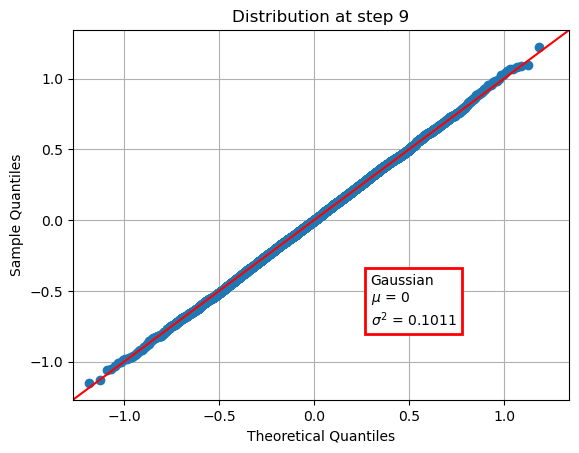

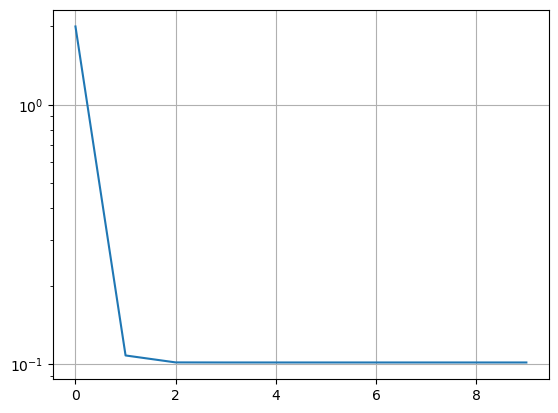

In [5]:

y = x_pred[:,:,0] - np.concatenate((x_0[None,:],x_truth),axis=0)

# Compare fit
idx_t = 9
qqplot(y[idx_t,:],0,x_pred[idx_t,0,1],title="Distribution at step %d"%idx_t)
plt.show()

plt.plot(x_pred[:,0,1])
plt.yscale('log')
plt.grid('on')
plt.show()
